# Plotting notebook for comparison experiments

### i.e. figure 4, figure xx

In [1]:
import numpy as np
import sempler
import sempler.generators

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D

import pickle
import os

import ut_lvcm.utils as utils
import ut_lvcm.metrics

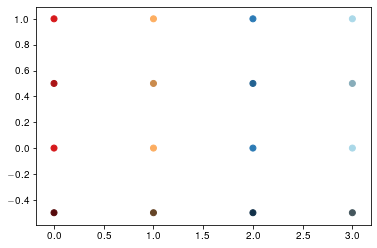

In [2]:
# Set tex formatting for plots
from matplotlib import rc
#rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')

# Colors
def to_rgb(H, b=1, a=1, w=0):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(min(1,int(h[i:i+2], 16) / 256 * b + w) for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ['#d7191c', '#fdae61', '#2c7bb6', '#abd9e9']
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
colors = to_rgb(base)
colorsa = to_rgb(base, b=0.8)
colorsb = to_rgb(base, b=0.4)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

In [3]:
def read_result(filename):
    if os.path.getsize(filename) > 0:
        with open(filename, "rb") as f:
            return pickle.load(f)

In [4]:
methods = ["ut_lvce", "backshift", "causal_dantzig", "lrps"]
names = ["UT-LVCE", "backShift", "Causal Dantzig", "LRPS+GES"]
names_methods = list(zip(names,methods))

In [5]:
def process_results(all_files, what='parents', debug=False, exclude=[]):
    # Iterate over intervention sizes
    values = {}
    supergraphs = {}
    size_initial = {}
    for i,files_size_I in enumerate(all_files):  
        # Iterate over sample sizes
        dict_Ns = {}
        supergraphs_Ns = {}
        size_initial_Ns = {}
        for j,file_n in enumerate(files_size_I):
            args, test_cases, results = read_result(file_n)
            # Check that intervention size is consistent
            if j == 0:
                size_I = args.size_I
                print("  |I| =", size_I) if debug else None
            if j > 0:
                assert size_I == args.size_I
            # Iterate over methods            
            dict_methods = {}            
            print("    n =", args.n) if debug else None
            # If looking at parent estimates                        
            if what=='parents':                                
                for (name,method) in names_methods:
                    if name in exclude:
                        continue
                    print("      method =", name) if debug else None
                    t1 = np.array(results['t1_%s' % method])
                    t2 = np.array(results['t2_%s' % method])
                    # Store results for this method
                    dict_methods[name] = (t1,t2)
            # If looking at I-MEC estimates            
            elif what=='graphs':
                truth = [utils.imec(m.A, I) for m,I in test_cases]
                estimates = {}
                if 'LRPS+GES' not in exclude:
                    estimates['LRPS+GES'] = [utils.all_dags(cpdag) for cpdag in results['graphs_lrps']]
                if 'backShift' not in exclude:
                    estimates['backShift'] = [[A] for A in results['graphs_backshift']]
                if 'UT-LVCE' not in exclude:
                    estimates['UT-LVCE'] = [utils.imec(m.A,I) for (m,I,_),_ in results['ut_lvce_output']]
                    # Count instances of GES upergraphs for binning
                    all_initial_graphs = [h['initial_graphs'] for _,h in results['ut_lvce_output']]
                    counts = np.zeros(len(truth))
                    sizes = np.zeros(len(truth))
                    for j,(true_imec,initial_graphs) in enumerate(zip(truth,all_initial_graphs)):
                        sizes[j] = len(initial_graphs)
                        for A0 in initial_graphs:
                            if np.array([utils.is_supergraph(A0, A) for A in true_imec]).any():
                                 counts[j] += 1
                    supergraphs_Ns[args.n] = counts
                    size_initial_Ns[args.n] = sizes
                for name in [name for name in names if name not in exclude + ['Causal Dantzig']]:
                    print("      method =", name) if debug else None
                    t1 = np.zeros(len(truth))
                    t2 = np.zeros(len(truth))
                    for j, true_imec in enumerate(truth):
                        t1[j] = ut_lvcm.metrics.type_1_structc(estimates[name][j], true_imec)
                        t2[j] = ut_lvcm.metrics.type_2_structc(estimates[name][j], true_imec)
                    dict_methods[name] = (t1, t2)
            # Store results for this sample size
            dict_Ns[args.n] = dict_methods            
        # Store results for this intervention size
        values[size_I] = dict_Ns
        supergraphs[size_I] = supergraphs_Ns
        size_initial[size_I] = size_initial_Ns
    return values, supergraphs, size_initial

In [6]:
def plot_roc_I(ax,values,mean=True,label_y=False,xticks=None,legend=None):
    # Parameters
    method_markers = {
        "UT-LVCE": {'fillstyle': 'right', 'markerfacecolor': colors[0], 'markerfacecoloralt': colorsa[0], 'markeredgecolor': colorsb[0]},
        "backShift": {'fillstyle': 'full', 'markerfacecolor': colors[1], 'markerfacecoloralt': colorsa[1], 'markeredgecolor': colorsb[1]},
        "Causal Dantzig": {'fillstyle': 'full', 'markerfacecolor': colors[2], 'markerfacecoloralt': colorsa[2], 'markeredgecolor': colorsb[2]},
        "LRPS+GES": {'fillstyle': 'top', 'markerfacecolor': colors[3], 'markerfacecoloralt': colorsa[3], 'markeredgecolor': colorsb[3]}
    }
    markers_n = dict(zip([100,500,1000,10000], ['D', 'o', 'X', '.']))
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]    
    # Plot
    used_ns, used_methods = set(), set()   
    for n, dict_n in values.items():
        used_ns.add(n)
        for name, (t1,t2) in dict_n.items():
            used_methods.add(name)
            x, y = (t1.mean(),1-t2.mean()) if mean else (t1, 1-t2)
            ax.plot(x, y,
                    marker=markers_n[n],
                    markersize=9,
                    zorder=10 + n,
                    clip_on=False,
                    markeredgewidth=0.7,
                    **method_markers[name])
    # Compose legend
    if legend is not None:
        used_ns = sorted(used_ns)

        # Methods
        method_entries = [Line2D([0], [0],                                 
                                 linestyle='None',
                                 marker='s',
                                 markersize=8,
                                 **method_markers[name]) for name in used_methods]
        method_strings = [name for name in used_methods]        
        # n
        sample_size_entries = [Line2D([0], [0], linestyle='None', color='gray', marker=markers_n[n]) for n in used_ns]
        sample_size_strings = ["$n = %d$" % n for n in used_ns]
        # Putting it all together
        entries = method_entries + sample_size_entries
        strings = method_strings + sample_size_strings
        pos, ncol = legend
        ax.legend(entries, strings, bbox_to_anchor=pos, ncol=ncol)#len(entries))
    
    # Other formatting
    #ax.set_ylim(lim)
    #ax.set_xlim(lim)
    ax.set_xlabel("avg. FDP")
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_ylim([-0.04, 1.04])
    if label_y:        
        ax.set_yticklabels(yticks)
        ax.set_ylabel("avg. TDP")        

**Files**

## Figure 4

In [7]:
files_hs = [
[
"comparison_experiments/results_1647797913__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1647797914__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647797915__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
],
[
"comparison_experiments/results_1647797919__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647797919__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1647797919__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:500/compiled_results.pickle",
],
[
"comparison_experiments/results_1647797920__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647797920__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1647797920__cluster:1_seed:42_tag:fffchs_disc:15_runs:10_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:500/compiled_results.pickle",
]]

In [8]:
values_parents,_,_ = process_results(files_hs, debug=False, what='parents')
values_graphs,_,_  = process_results(files_hs, debug=True, what='graphs')

  |I| = 10
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
  |I| = 19
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
  |I| = 20
    n = 100
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 1000
      method = UT-LVCE
      method = backShift
      method = LRPS+GES
    n = 500
      method = UT-LVCE
      method = backShift
      method = LRPS+GES


FileNotFoundError: [Errno 2] No such file or directory: 'figures/figure_comparisons_all.pdf'

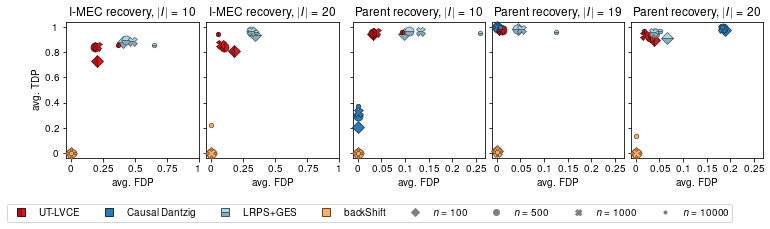

In [10]:
w = 2.5
plt.figure(figsize=(5*w,w))
outer = gridspec.GridSpec(1, 2, wspace=0.04, width_ratios=[2/5, 3/5], hspace=0)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[0], wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = outer[1], wspace=0.05)

# Plot 1
I = 10
plt.subplot(inner1[0])
ax = plt.gca()
plot_roc_I(ax, values_graphs[I], label_y=True, xticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title("I-MEC recovery, $|I|=%d$" % I)
ax.set_xlim([-0.04, 1])

# Plot 2
I = 20
plt.subplot(inner1[1])
ax = plt.gca()
plot_roc_I(ax, values_graphs[I], xticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title("I-MEC recovery, $|I|=%d$" % I)
ax.set_xlim([-0.04, 1])

# Plot 3
I = 10
plt.subplot(inner2[0])
ax = plt.gca()
plot_roc_I(ax, values_parents[I], xticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_title("Parent recovery, $|I|=%d$" % I)
ax.set_xlim([-0.01, 0.27])

# Plot 4
I = 19
plt.subplot(inner2[1])
ax = plt.gca()
plot_roc_I(ax, values_parents[I], xticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_title("Parent recovery, $|I|=%d$" % I)
ax.set_xlim([-0.01, 0.27])

# Plot 5
I = 20
plt.subplot(inner2[2])
ax = plt.gca()
plot_roc_I(ax, values_parents[I], xticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25], legend=((0.8,-0.3),8))
ax.set_title("Parent recovery, $|I|=%d$" % I)
ax.set_xlim([-0.01, 0.27])


# Save plot
plt.savefig("figures/figure_comparisons_all.pdf", bbox_inches='tight')

## Figure: violations of the Causal Dantzig assumptions

In [10]:
files_sh = [[
"comparison_experiments/results_1647722773__cluster:1_seed:42_tag:ffcsh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722773__cluster:1_seed:42_tag:ffcsh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1647722775__cluster:1_seed:42_tag:ffcsh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1647722776__cluster:1_seed:42_tag:ffcsh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:19_it:0_sl:0_n:10000/compiled_results.pickle",
]]


# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# SS - Soft interventions on observed and latents
# 12 jobs

files_ss = [
[
"comparison_experiments/results_1647722801__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1647722801__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:10000/compiled_results.pickle",
"comparison_experiments/results_1647722802__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722802__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:19_it:0_sl:0_n:500/compiled_results.pickle",
],
[
"comparison_experiments/results_1647722803__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1647722804__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:10000/compiled_results.pickle",
"comparison_experiments/results_1647722805__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722805__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:500/compiled_results.pickle",
]]

In [11]:
values_parents_ss, _, _ = process_results(files_ss, debug=False, what='parents', exclude=['LRPS+GES', 'backShift'])
values_parents_sh, _, _  = process_results(files_sh, debug=False, what='parents', exclude=['LRPS+GES', 'backShift'])

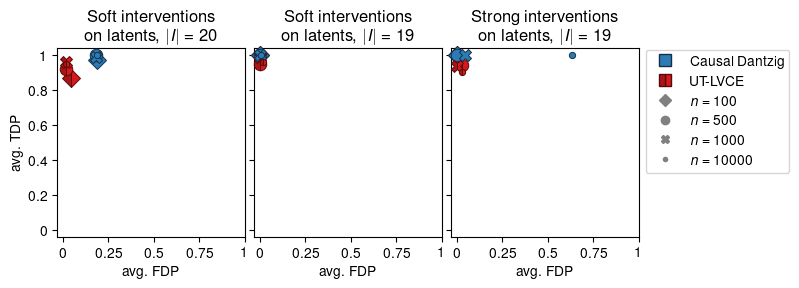

In [12]:
w = 2.5
xticks = [0, 0.25, 0.5, 0.75, 1]#, 1]#[0, 0.1, 0.2, 0.3]
xlim = [-0.03,1]#[-0.02, 0.78]
plt.figure(figsize=(3*w,w), dpi=100)
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0)

# Plot 1: I = 20, soft interventions
I = 20
plt.subplot(gs[0])
ax = plt.gca()
plot_roc_I(ax, values_parents_ss[I], label_y=True, xticks=xticks,legend=None)
ax.set_title("Soft interventions\non latents, $|I|=%d$" % I)
ax.set_xlim(xlim)

# Plot 1: I = 19, soft interventions
I = 19
plt.subplot(gs[1])
ax = plt.gca()
plot_roc_I(ax, values_parents_ss[I], label_y=False, xticks=xticks,legend=None)
ax.set_title("Soft interventions\non latents, $|I|=%d$" % I)
ax.set_xlim(xlim)

# Plot 3: I = 19, strong interventions
I = 19
plt.subplot(gs[2])
ax = plt.gca()
plot_roc_I(ax, values_parents_sh[I], label_y=False, xticks=xticks,legend=((1,1.03),1)) # ((1, 0.6),1))
ax.set_title("Strong interventions\non latents, $|I|=%d$" % I)
ax.set_xlim(xlim)

filename = "figure_dantzig_assumptions.pdf"
if filename is not None:
    plt.savefig("figures/%s" % filename, bbox_inches='tight')

## Figure: Robustness to different intervention strengths

In [13]:
files_hh = [
[
"comparison_experiments/results_1647722770__cluster:1_seed:42_tag:ffchh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
"comparison_experiments/results_1647722770__cluster:1_seed:42_tag:ffchh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1647722772__cluster:1_seed:42_tag:ffchh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
]
]

files_hs = [
[
"comparison_experiments/results_1647722769__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1647722770__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722770__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
]]

files_sh = [
[
"comparison_experiments/results_1647722768__cluster:1_seed:42_tag:ffcsh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1647722769__cluster:1_seed:42_tag:ffcsh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722770__cluster:1_seed:42_tag:ffcsh_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:1.0_i_psi_hi:5.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
]]

files_ss = [
[
"comparison_experiments/results_1647722798__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722798__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1647722799__cluster:1_seed:42_tag:ffcss_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:3.0_i_v_hi:6.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
]]

In [14]:
exclude = ['backShift'] # ['LRPS+GES', 'backShift']

In [15]:
values_ss, _, _ = process_results(files_ss, debug=False, what='graphs', exclude=exclude)

In [16]:
values_sh, _, _ = process_results(files_sh, debug=False, what='graphs', exclude=exclude)

In [17]:
values_hs, _, _ = process_results(files_hs, debug=False, what='graphs', exclude=exclude)

In [18]:
values_hh, _, _ = process_results(files_hh, debug=False, what='graphs', exclude=exclude)

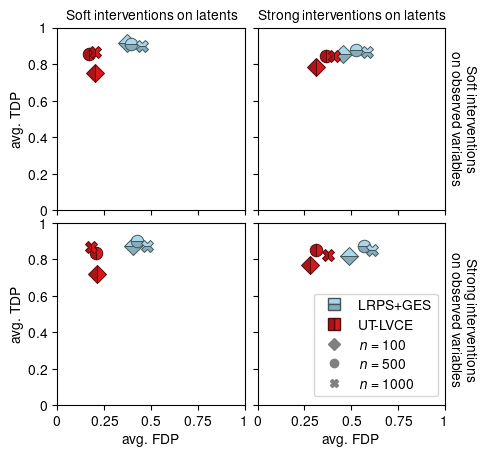

In [19]:
w = 2.5
xticks = [0, 0.25, 0.5, 0.75, 1]#[0, 0.1, 0.2, 0.3]
plt.figure(figsize=(2*w,2*w), dpi=100)
gs = gridspec.GridSpec(2, 2, wspace=0.07, hspace=0.07)

I = 10
s = 10

# Plot
plt.subplot(gs[0,0])
ax = plt.gca()
plot_roc_I(ax, values_ss[I], label_y=True, xticks=xticks,legend=None)
ax.set_title("Soft interventions on latents", size=s)
ax.set_xticklabels([])
ax.set_ylim([0,1])

# Plot
plt.subplot(gs[1,0])
ax = plt.gca()
plot_roc_I(ax, values_hs[I], label_y=True, xticks=xticks,legend=None)
ax.set_ylim([0,1])

# Plot
plt.subplot(gs[0,1])
ax = plt.gca()
plot_roc_I(ax, values_sh[I], label_y=False, xticks=xticks,legend=None)
ax.set_title("Strong interventions on latents", size=s)
ax.text(1.1,0.5,"Soft interventions\non observed variables", ha='center', va='center', rotation=270, size=s)
ax.text(1.1,-0.6,"Strong interventions\non observed variables", ha='center', va='center', rotation=270, size=s)
ax.set_xticklabels([])
ax.set_ylim([0,1])

# Plot
plt.subplot(gs[1,1])
ax = plt.gca()
plot_roc_I(ax, values_hh[I], label_y=False, xticks=xticks,legend=((1,0.65),1))
ax.set_title("", size=s)
ax.set_ylim([0,1])

filename = "figure_robustness.pdf"
if filename is not None:
    plt.savefig("figures/%s" % filename, bbox_inches='tight')

## Figure: Effect of GES estimate not being a supergraph of the true I-MEC

In [20]:
def plot_roc_bin(ax,values_yes,values_no,mean=True,label_y=False,xticks=None,legend=None):
    # Parameters
    marker_opts =  [{'fillstyle': 'right', 'markerfacecolor': colors[0], 'markerfacecoloralt': colorsa[0], 'markeredgecolor': colorsb[0]},
                    {'fillstyle': 'top', 'markerfacecolor': colors[2], 'markerfacecoloralt': colorsa[2], 'markeredgecolor': colorsb[2]}]
    markers_n = dict(zip([100,500,1000,10000], ['D', 'o', 'X', '.']))
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    # Plot
    for i,values in enumerate([values_yes, values_no]):
        used_ns, used_methods = set(), set()   
        for n, dict_n in values.items():
            used_ns.add(n)
            for name, (t1,t2) in dict_n.items():
                used_methods.add(name)
                x, y = (t1.mean(),1-t2.mean()) if mean else (t1, 1-t2)
                ax.plot(x, y,
                        marker=markers_n[n],
                        markersize=9,
                        zorder=10 + n,
                        clip_on=False,
                        markeredgewidth=0.7,
                        **marker_opts[i])
    # Compose legend
    if legend is not None:
        used_ns = sorted(used_ns)

        # Methods
        method_entries = [Line2D([0], [0],                                 
                                 linestyle='None',
                                 marker='s',
                                 markersize=8,
                                 **marker_opts[j]) for j in [0,1]]
        method_strings = ["Yes", "No"]
        # n
        sample_size_entries = [Line2D([0], [0], linestyle='None', color='gray', marker=markers_n[n]) for n in used_ns]
        sample_size_strings = ["$n = %d$" % n for n in used_ns]
        # Putting it all together
        entries = method_entries + sample_size_entries
        strings = method_strings + sample_size_strings
        pos, ncol = legend
        ax.legend(entries, strings, bbox_to_anchor=pos, ncol=ncol, title="GES output\ncontains\nsupergraph", prop = {'size': 8}, title_fontsize=10)
    
    # Other formatting
    #ax.set_ylim(lim)
    #ax.set_xlim(lim)
    ax.set_xlabel("avg. FDP")
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_ylim([-0.04, 1.04])
    if label_y:        
        ax.set_yticklabels(yticks)
        ax.set_ylabel("avg. TDP")        

In [21]:
files_hs = [
[
"comparison_experiments/results_1647722769__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1647722770__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722770__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:10_it:0_sl:0_n:1000/compiled_results.pickle",
],
[
"comparison_experiments/results_1647722775__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:500/compiled_results.pickle",
"comparison_experiments/results_1647722776__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:100/compiled_results.pickle",
"comparison_experiments/results_1647722776__cluster:1_seed:42_tag:ffchs_disc:15_runs:1_m:ubil_min_parents:2_G:50_k:2.1_p:20_w_lo:0.7_w_hi:0.7_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:20_it:1_sl:0_n:1000/compiled_results.pickle",
]]

In [22]:
values_hs, supergraphs_hs, size_initial_graphs_hs = process_results(files_hs, debug=False, what='graphs', exclude=exclude)

**Partition results into cases where GES output contained at least one supergraph of an I-MEC representative**

In [24]:
values_hs_yes = {}
values_hs_no = {}
for size_I,dict_I in values_hs.items():
    #print(size_I)
    yes_dict_I, no_dict_I = {}, {}
    for n, dict_n in dict_I.items():
        #print(" ", n)
        (t1,t2) = dict_n['UT-LVCE']
        yes_mask = supergraphs_hs[size_I][n] > 0
        no_mask = supergraphs_hs[size_I][n] == 0
        yes_dict_I[n] = {'UT-LVCE': (t1[yes_mask], t2[yes_mask])}
        no_dict_I[n] = {'UT-LVCE': (t1[no_mask], t2[no_mask])}
    values_hs_yes[size_I] = yes_dict_I
    values_hs_no[size_I] = no_dict_I

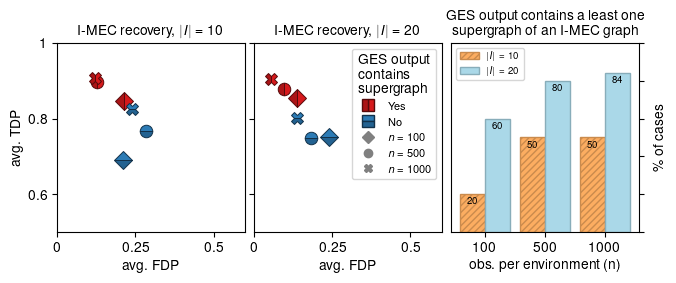

In [26]:
w = 2.5
xticks = [0, 0.25, 0.5, 0.75, 1]#[0, 0.1, 0.2, 0.3]
plt.figure(figsize=(3*w,w), dpi=100)
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0)

xlim = [0, 0.6]
# Plot 1: I = 10
I = 10
plt.subplot(gs[0])
ax = plt.gca()
plot_roc_bin(ax, values_hs_yes[I], values_hs_no[I], label_y=True, xticks=xticks,legend=None)#((-0.25,1),1))
ax.set_title("I-MEC recovery, $|I|=%d$" % I, size=10)
ax.set_xlim(xlim)
ax.set_ylim(0.5, 1)

# Plot 1: I = 20
I = 20
plt.subplot(gs[1])
ax = plt.gca()
plot_roc_bin(ax, values_hs_yes[I], values_hs_no[I], label_y=False, xticks=xticks,legend=((1,1),1))#None)
ax.set_title("I-MEC recovery, $|I|=%d$" % I, size=10)
ax.set_xlim(xlim)
ax.set_ylim(0.5, 1)


# --------------------------------------------------
# Histogram
supergraphs = supergraphs_hs
Is_to_plot = [10,20]
total_cases = 50
plt.subplot(gs[2])
ax = plt.gca()
j = 0
dev = 0.42
c = [colors[i] for i in [1,3]]
cb = [colorsa[i] for i in [1,3]]
hatch = ['/////', None] # / , \\ , | , - , + , x, o, O, ., *
for size_I, dict_I in supergraphs.items():
    if size_I not in Is_to_plot:
        continue
    ns_freq = sorted(zip(dict_I.keys(), [(counts > 0).sum() for counts in dict_I.values()]))
    Ns = [n for n,_ in ns_freq]
    freqs = np.array([f / total_cases for _,f in ns_freq]) * 100    
    
    x = np.arange(len(Ns)) + dev*j
    ax.bar(x, freqs, width=dev, label="$|I|=%d$" % size_I, color=c[j], edgecolor=cb[j], hatch=hatch[j])
    
    for i,freq in enumerate(freqs):        
        ax.text(i+dev*j,freq-5,("%d" % (freq)), ha='center',size=7)
    
    j += 1
ax.set_xticks(np.arange(len(Ns)) + dev / 2)
ax.set_xticklabels(Ns)
ax.set_ylim(0,100)
ax.set_title("GES output contains a least one\nsupergraph of an I-MEC graph", size=10)
ax.set_ylabel("\% of cases")
ax.set_xlabel("obs. per environment (n)")
ax.yaxis.tick_right()
ax.set_yticklabels([])
ax.yaxis.set_label_position("right")
ax.legend(ncol=1, prop={'size': 7})


filename = "figure_ges_binning.pdf"
if filename is not None:
    plt.savefig("figures/%s" % filename, bbox_inches='tight')

In [ ]:
raise Exception("Stop")

In [ ]:
medianprops = {'linestyle': None}

In [ ]:
def plot_boxplot(ax, supergraphs, sizes_initial, plot_type='boxplot', title=False, label_y=True, debug=False):
    # --------------------------------------------------
    # Histogram        
    ax = plt.gca()    
    dev = 0.5
    Ns = sorted(list(supergraphs.keys()))
    all_ratios = []
    for n in Ns:        
        print(n) if debug else None
        counts = supergraphs[n]
        initial_set_sizes = sizes_initial[n]
        print("  ",counts) if debug else None
        print("  ",initial_set_sizes) if debug else None
        ratios = counts / initial_set_sizes
        all_ratios.append(ratios)
    
    x = np.arange(len(Ns))
    if plot_type == 'boxplot' or plot_type=='both':
        ax.boxplot(all_ratios, positions=x, showmeans=False, medianprops=medianprops)#, color=c[j], edgecolor=cb[j], hatch=hatch[j])        
    if plot_type=='violin' or plot_type=='both':
        ax.violinplot(all_ratios, positions=x, showmeans=True)

    ax.set_xticks(np.arange(len(Ns)))
    ax.set_xticklabels(Ns)
    ax.set_title("Ratio of GES output which are\nsupergraphs of an I-MEC graph", size=10) if title else None
    ax.set_xlabel("obs. per environment (n)")
    ax.yaxis.tick_right()

In [ ]:
plot_type = 'both'#xplot' # 'both'

w = 2.5
xticks = [0, 0.25, 0.5, 0.75, 1]#[0, 0.1, 0.2, 0.3]
plt.figure(figsize=(2*w,2*w), dpi=100)
gs = gridspec.GridSpec(2, 2, wspace=0.05, hspace=0.05)
xlim = [0, 0.6]

# --------------------------------------------
# |I| = 10


# ROC plot
I = 10
plt.subplot(gs[0,0])
ax = plt.gca()
plot_roc_bin(ax, values_hs_yes[I], values_hs_no[I], label_y=True, xticks=xticks,legend=None)#((-0.25,1),1))
ax.set_title("I-MEC recovery", size=10)
ax.set_xlim(xlim)
ax.set_ylim(0.5, 1)
ax.set_xticklabels([])
ax.text(0.5,0.55,"$|I|=%d$" % I, ha='center', size=12)

# Violin plot
plt.subplot(gs[0,1])
plot_boxplot(ax, supergraphs_hs[I], size_initial_graphs_hs[I], title=True, plot_type=plot_type)


# --------------------------------------------
# |I| = 20

# ROC plot
I = 20
plt.subplot(gs[1,0])
ax = plt.gca()
plot_roc_bin(ax, values_hs_yes[I], values_hs_no[I], label_y=True, xticks=xticks,legend=((1,-1),3))#None)
ax.set_xlim(xlim)
ax.set_ylim(0.5, 1)
ax.text(0.5,0.55,"$|I|=%d$" % I, ha='center', size=12)

# Violin plot
plt.subplot(gs[1,1])
plot_boxplot(ax, supergraphs_hs[I], size_initial_graphs_hs[I], plot_type=plot_type)


filename = "figure_ges_binning_2.pdf"
if filename is not None:
    plt.savefig("figures/%s" % filename, bbox_inches='tight')